In [76]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
import calendar

warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [78]:
#load fraudulent profile 1375
badguy = pd.read_excel('/Users/marcjene/fraud_detection/sonya_mt/1375_new.xlsx')
badguy['Timestamp'] = pd.to_datetime(badguy['Timestamp'])
badguy = badguy.rename(columns={"kWh": "power"})
badguy.head()

,Timestamp,power
0,2009-07-27 00:00:00,1.184
1,2009-07-27 00:30:00,0.758
2,2009-07-27 01:00:00,0.461
3,2009-07-27 01:30:00,0.425
4,2009-07-27 02:00:00,0.517


In [79]:
badguy.dtypes

Timestamp    datetime64[ns]
power               float64
dtype: object

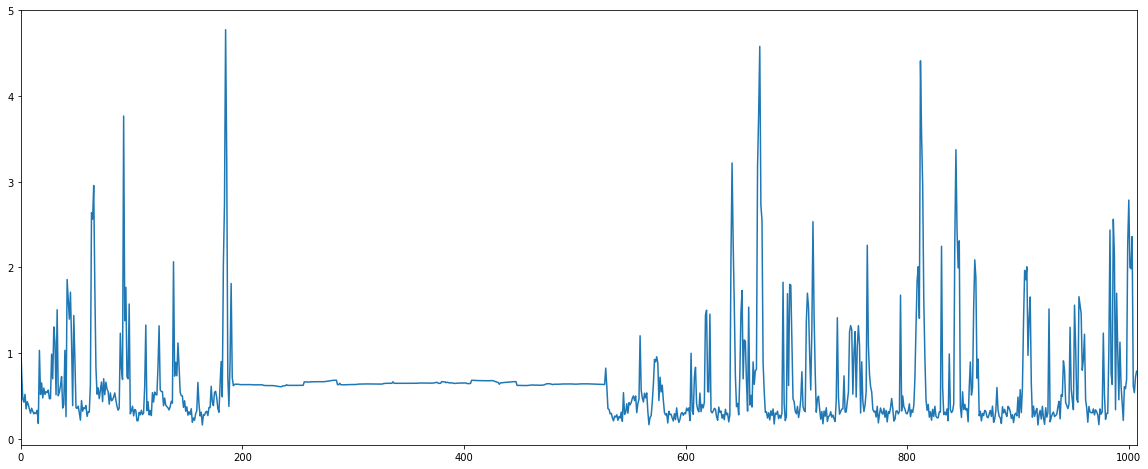

In [80]:
badguy['power'][0:1008].plot(figsize = (20,8))
plt.show()

In [81]:
df_bg=badguy.copy()

df_bg['date'] = df_bg['Timestamp'].apply(lambda x:x.strftime('%Y%m%d'))

df_bg['time'] = df_bg['Timestamp'].apply(lambda x:x.strftime('%H:%M'))

df_bg = df_bg.drop(['Timestamp'], axis=1)
df_bg.head()

,power,date,time
0,1.184,20090727,00:00
1,0.758,20090727,00:30
2,0.461,20090727,01:00
3,0.425,20090727,01:30
4,0.517,20090727,02:00


# Approach 1
### K-Means + Artificial Features

In [82]:
list_days=df_bg['date'].unique()
list_days

array(['20090727', '20090728', '20090729', '20090730', '20090731',
       '20090108', '20090208', '20090308', '20090408', '20090508',
       '20090608', '20090708', '20090808', '20090908', '20091008',
       '20091108', '20091208', '20090813', '20090814', '20090815',
       '20090816'], dtype=object)

In [83]:
#How many different days are there?
n=df_bg['date'].nunique()
n

21

<Figure size 432x288 with 0 Axes>

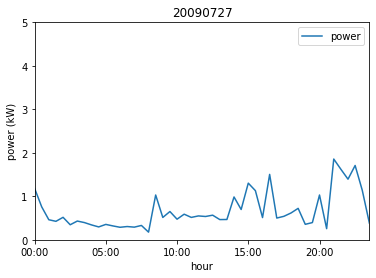

<Figure size 432x288 with 0 Axes>

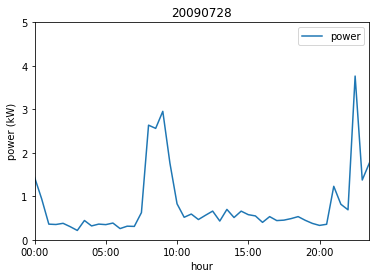

<Figure size 432x288 with 0 Axes>

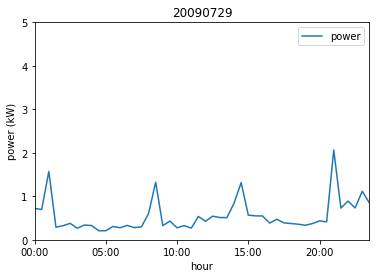

<Figure size 432x288 with 0 Axes>

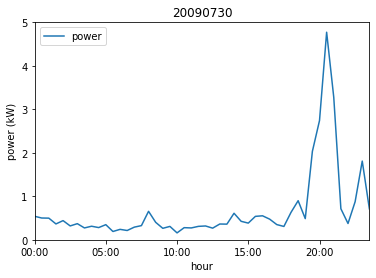

<Figure size 432x288 with 0 Axes>

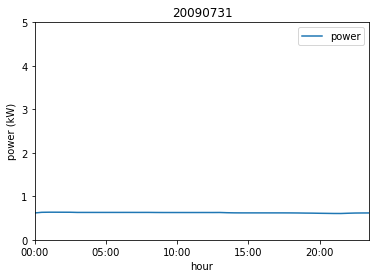

<Figure size 432x288 with 0 Axes>

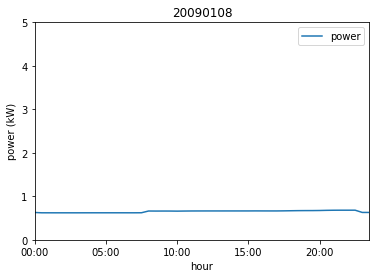

<Figure size 432x288 with 0 Axes>

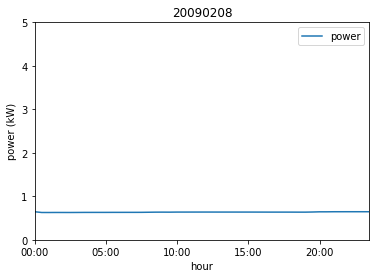

<Figure size 432x288 with 0 Axes>

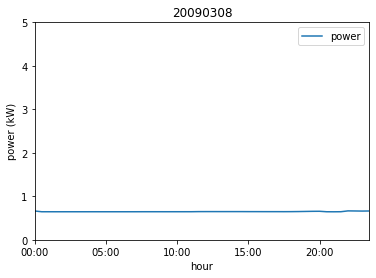

<Figure size 432x288 with 0 Axes>

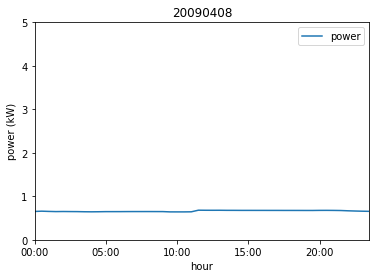

<Figure size 432x288 with 0 Axes>

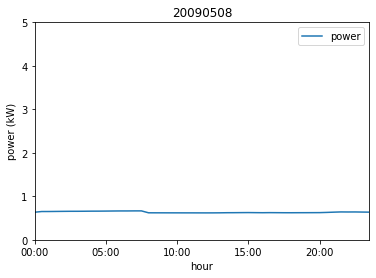

In [84]:
for day in list_days[0:10]:
    df = df_bg.loc[df_bg['date']==day]
    df = df.set_index('time')
    df
    new_df=df.drop(['date'], axis=1)
    new_df
    plt.figure()
    new_df.plot()
    plt.legend(loc='best')
    plt.title(day)
    plt.xlabel('hour')
    plt.ylim(0,5)
    plt.ylabel('power (kW)')

In [85]:
daily_meter = pd.DataFrame()
for day in list_days:
    E_ref = df_bg.loc[df_bg['date']==day,('time','date','power')]
    
    if E_ref['power'].max()==0:
        E_ref['norm_power']=0
    else:
        E_ref['norm_power'] = E_ref['power']/E_ref['power'].max()
        
    E_ref['date']=day
    E_ref.reset_index(inplace=True)
    daily_meter=daily_meter.append(E_ref,ignore_index=True)
    
daily_meter=daily_meter.set_index('index')
daily_meter.head()

,time,date,power,norm_power
index,,,,
0,00:00,20090727,1.184,0.637588
1,00:30,20090727,0.758,0.408185
2,01:00,20090727,0.461,0.248250
3,01:30,20090727,0.425,0.228864
4,02:00,20090727,0.517,0.278406


<Figure size 432x288 with 0 Axes>

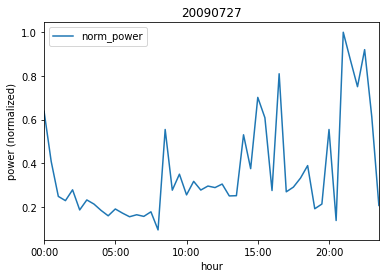

<Figure size 432x288 with 0 Axes>

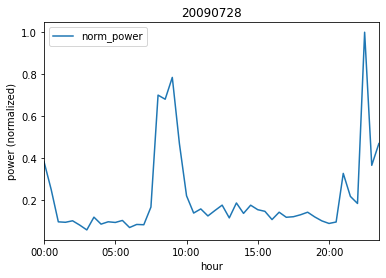

<Figure size 432x288 with 0 Axes>

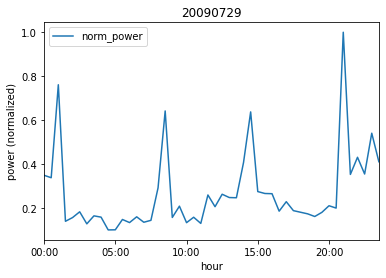

<Figure size 432x288 with 0 Axes>

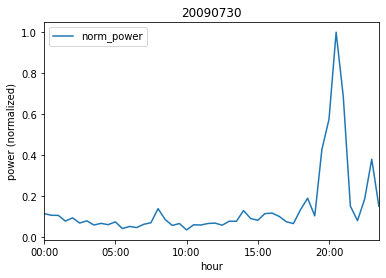

<Figure size 432x288 with 0 Axes>

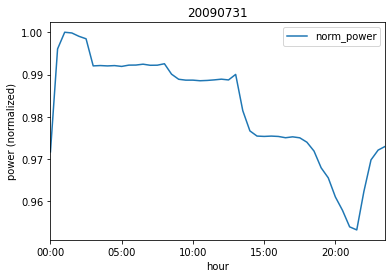

<Figure size 432x288 with 0 Axes>

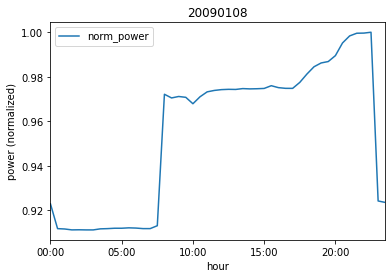

<Figure size 432x288 with 0 Axes>

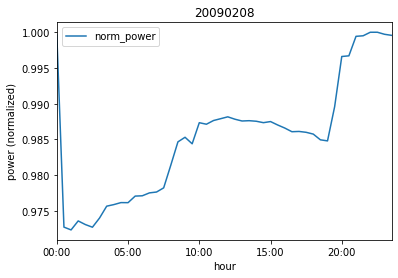

<Figure size 432x288 with 0 Axes>

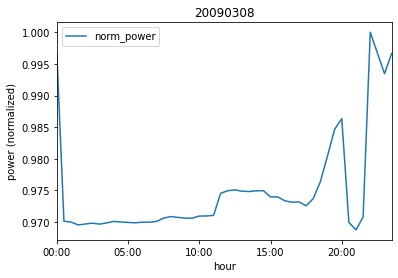

<Figure size 432x288 with 0 Axes>

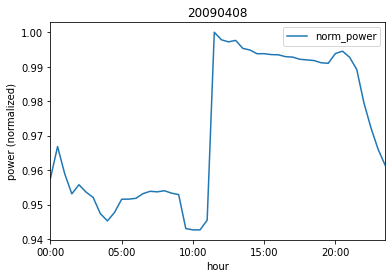

<Figure size 432x288 with 0 Axes>

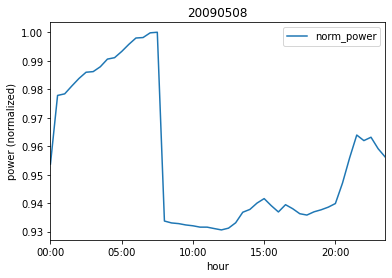

In [86]:
for day in list_days[0:10]:
    df = daily_meter.loc[df_bg['date']==day]
    df = df.set_index('time')
    df
    new_df=df.drop(['date','power'], axis=1)
    new_df
    plt.figure()
    new_df.plot()
    plt.legend(loc='best')
    plt.title(day)
    plt.xlabel('hour')
    plt.ylabel('power (normalized)')

In [87]:
df_cluster=daily_meter.copy()

In [88]:
#Example of how to count cuts
df = df_cluster[df_cluster['date']=='20090727']
mean = df['norm_power'].mean()
power = df.iloc[0]['norm_power']
above_0 = (power>mean)
prev_above = above_0
cuts = 0
i=0
for index, row in df.iterrows():
    if i!=0:
        power = row['norm_power']
        above = power>mean
        if above!=prev_above:
            cuts += 1
            above = (power>mean)
        prev_above=above
        i+=1
        #print(i, cuts)
    else:
        i+=1
        #print(i, cuts)
        
if above_0!=above:
    cuts += 1
    
print (cuts)

14


In [89]:
#CUTS FUNCTION
def cuts(df,mean):
    power = df.iloc[0]['norm_power']
    above_0 = (power>mean)
    prev_above = above_0
    cuts = 0
    i=0
    for index, row in df.iterrows():
        if i!=0:
            power = row['norm_power']
            above = power>mean
            if above!=prev_above:
                cuts += 1
                above = (power>mean)
            prev_above=above
            i+=1
        else:
            i+=1
    if above_0!=above:
        cuts += 1    
    return (cuts)

In [90]:
#Example of how to count slopes
df = df_cluster[df_cluster['date']=='20090727']
mean = df['norm_power'].mean()
power = df.iloc[0]['norm_power']
previous_p = power
inc = 0
dec = 0
power_0 = power
for index, row in df.iterrows():
    #print(power, inc, dec)
    power = row['norm_power']
    if power>(previous_p+0.5*mean):
        inc += 1
    elif power<(previous_p-0.5*mean):
        dec += 1
    previous_p = power
if power_0>(previous_p+0.5*mean):
    inc += 1
elif power_0>(previous_p-0.5*mean):
    dec += 1
print (inc,dec)

7 8


In [91]:
#SLOPES FUNCTION
def deep_slopes(df, mean):
    power = df.iloc[0]['norm_power']
    previous_p = power
    inc = 0
    dec = 0
    power_0 = power
    for index, row in df.iterrows():
        #print(power, inc, dec)
        power = row['norm_power']
        if power>(previous_p+0.5*mean):
            inc += 1
        elif power<(previous_p-0.5*mean):
            dec += 1
        previous_p = power
    if power_0>(previous_p+0.5*mean):
        inc += 1
    elif power_0>(previous_p-0.5*mean):
        dec += 1
    return (inc,dec)

In [92]:
#FEATURES SELECTION
df = pd.DataFrame(columns=['date','norm_mean','norm_median','norm_std','norm_mean_p1','norm_mean_p2','norm_mean_p3',
                           'n_cuts','inc','dec'])
meter_stat = pd.DataFrame(columns=['norm_mean','norm_median','norm_std','norm_mean_p1','norm_mean_p2','norm_mean_p3',
                                   'n_cuts','inc','dec'])

df_cluster['datetime'] =  pd.to_datetime(df_cluster['time'], format='%H:%M')

for day in list_days:
    daily_ref = df_cluster[df_cluster['date'] == day]
    
    mean = daily_ref['norm_power'].mean()
    
    std = daily_ref['norm_power'].std()
    
    median = daily_ref['norm_power'].median()
    
    daily_p1 = daily_ref[daily_ref['datetime'].dt.hour < 8]
    mean_p1 = daily_p1['norm_power'].mean()
    
    daily_p2 = daily_ref[(daily_ref['datetime'].dt.hour > 8) & (daily_ref['datetime'].dt.hour < 16)]
    mean_p2 = daily_p2['norm_power'].mean()
    
    daily_p3 = daily_ref[(daily_ref['datetime'].dt.hour > 16) & (daily_ref['datetime'].dt.hour < 24)]
    mean_p3 = daily_p3['norm_power'].mean()
    
    n_cuts = cuts(daily_ref,mean)
    
    inc, dec = deep_slopes(daily_ref,mean)
    
    df = df.append({'date':day,'norm_mean':mean,'norm_std':std, 'norm_median':median, 'norm_mean_p1':mean_p1,
                    'norm_mean_p2':mean_p2, 'norm_mean_p3':mean_p3, 'n_cuts':n_cuts, 'inc':inc, 'dec':dec},
                   ignore_index=True)
    
df_features=df
df_features.head()

,date,norm_mean,norm_median,norm_std,norm_mean_p1,norm_mean_p2,norm_mean_p3,n_cuts,inc,dec
0,20090727,0.361560,0.277060,0.227925,0.237042,0.363105,0.481729,14,7,8
1,20090728,0.212052,0.136786,0.203724,0.121946,0.223373,0.247961,6,3,7
2,20090729,0.268926,0.203246,0.182232,0.206607,0.257129,0.329803,6,7,5
3,20090730,0.141599,0.078148,0.181199,0.072177,0.072716,0.299093,6,5,6
4,20090731,0.982019,0.988637,0.012602,0.992915,0.984579,0.966653,2,0,1


In [93]:
df_features = df_features.set_index('date')

In [94]:
df_features.isnull().any().any()

False

In [95]:
# Importing StandardScaler method for SkLearn 
from sklearn.preprocessing import StandardScaler

# Creating the instance for Standard Scaler 
scaler = StandardScaler()

# Fitting the scaler with meter_stat
scaler.fit(df_features)

# Transforming the meter_stat df into an scaled one. 
df_features_scaled = pd.DataFrame(scaler.transform(df_features), index=df_features.index, columns=df_features.columns)

In [96]:
df_features_scaled.head(10)

,norm_mean,norm_median,norm_std,norm_mean_p1,norm_mean_p2,norm_mean_p3,n_cuts,inc,dec
date,,,,,,,,,
20090727,-0.403812,-0.427562,0.789089,-0.481110,-0.373343,-0.353662,1.602486,0.922807,0.898717
20090728,-0.843047,-0.794517,0.541573,-0.776595,-0.773375,-1.163210,-0.348367,-0.327448,0.599145
20090729,-0.675960,-0.620658,0.321757,-0.559245,-0.676737,-0.879786,-0.348367,0.922807,0.000000
20090730,-1.050027,-0.947914,0.311193,-0.904365,-1.204688,-0.986137,-0.348367,0.297680,0.299572
20090731,1.419016,1.433920,-1.413154,1.459422,1.405855,1.325641,-1.323793,-1.265139,-1.198289
20090108,1.339596,1.392217,-1.201413,1.252990,1.373433,1.372130,-1.323793,-1.265139,-1.198289
20090208,1.428810,1.427265,-1.455549,1.418139,1.413244,1.418530,-0.836080,-1.265139,-1.198289
20090308,1.398647,1.387804,-1.457174,1.404777,1.373592,1.377710,-0.836080,-1.265139,-1.198289
20090408,1.388481,1.375798,-1.327755,1.357861,1.386708,1.391707,-1.323793,-1.265139,-1.198289


In [97]:
#Drop not a number values
df_features_scaled=df_features_scaled.dropna()
df_features=df_features.dropna()
df_features_db=df_features_scaled
nan_rows = df_features_scaled[df_features_scaled.isnull().any(1)]
nan_rows

,norm_mean,norm_median,norm_std,norm_mean_p1,norm_mean_p2,norm_mean_p3,n_cuts,inc,dec
date,,,,,,,,,


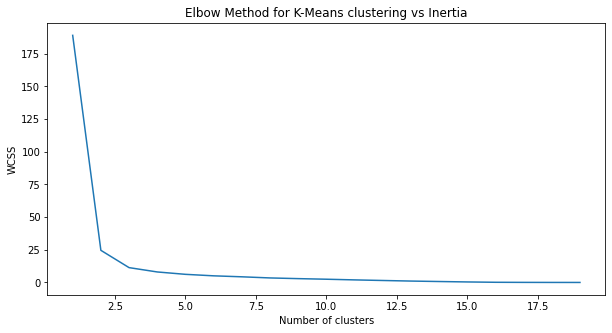

In [98]:
# Importing the library for KMeans 
from sklearn.cluster import KMeans

# Creating an empty list 
wcss = []

#ELBOW METHOD
# Creating a for loop for clusters between 1 and 12. 
# We create an instance, we fit the model and calculate the inertia 
for i in range(1, 20):
    kmeans = KMeans(n_clusters = i, init = "k-means++", max_iter = 300, n_init = 10, random_state = 42)
    kmeans.fit(df_features_scaled)
    wcss.append (kmeans.inertia_)
# Plotting the inertia in front of each iteration 
plt.figure(figsize=(10,5))
plt.plot(range(1, 20), wcss)

# Setting aesthetics of the plot. 
plt.title('Elbow Method for K-Means clustering vs Inertia')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.show()

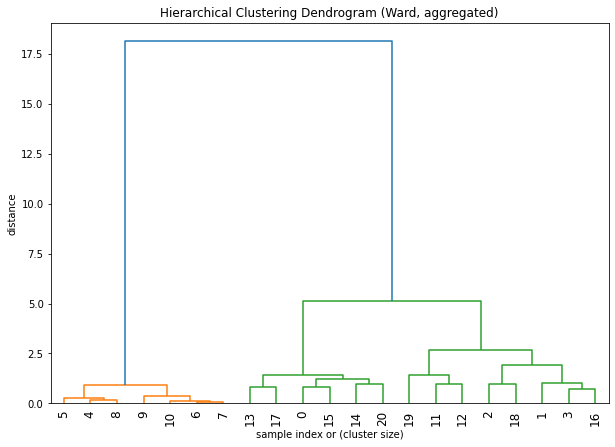

In [99]:
#DENDOGRAM METHOD

# Hierarchical algorithm for clustering. Import hierarchical algorithm method. 
from scipy.cluster.hierarchy import dendrogram, linkage

# Creating a new hierarchical algorithm  
linkage_matrix = linkage(df_features_scaled, 'ward')

# Creating the figure 
figure = plt.figure(figsize=(10, 7))

# The hierarchical algorithm will be reduced, only showing the converged clusters.
dendrogram(
    linkage_matrix,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=24,                   # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,   # to get a distribution impression in truncated branches
)

# Setting aesthetics of the plot 
plt.title('Hierarchical Clustering Dendrogram (Ward, aggregated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
plt.show()

In [100]:
#CLUSTERING
# We assume 2 clusters 
kmeans = KMeans(n_clusters=2)

# Fitting the input data
kmeans.fit(df_features_scaled)

# Including the labels in the database 
df_features['labels'] = kmeans.labels_

In [101]:
# Counting the number of clients under each label. 
df_features['labels'].value_counts()

0    14
1     7
Name: labels, dtype: int64

In [102]:
print(f"The inertia of the model with k=2 is {kmeans.inertia_}")

The inertia of the model with k=2 is 24.58398868478444


In [103]:
df_features[df_features.index=='20090727']

,norm_mean,norm_median,norm_std,norm_mean_p1,norm_mean_p2,norm_mean_p3,n_cuts,inc,dec,labels
date,,,,,,,,,,
20090727,0.36156,0.27706,0.227925,0.237042,0.363105,0.481729,14,7,8,0


In [104]:
df_features[df_features.index=='20090108']

,norm_mean,norm_median,norm_std,norm_mean_p1,norm_mean_p2,norm_mean_p3,n_cuts,inc,dec,labels
date,,,,,,,,,,
20090108,0.954986,0.972695,0.033305,0.912505,0.973254,0.980077,2,0,1,1


In [105]:
v_label=[]
for ind in daily_meter.index:
    date = daily_meter['date'][ind]
    if date in df_features.index:
        v_label=v_label+[df_features['labels'][date]]
    else:
        v_label=v_label+['NaN']
daily_meter['label']=v_label
daily_meter.head()

,time,date,power,norm_power,label
index,,,,,
0,00:00,20090727,1.184,0.637588,0
1,00:30,20090727,0.758,0.408185,0
2,01:00,20090727,0.461,0.248250,0
3,01:30,20090727,0.425,0.228864,0
4,02:00,20090727,0.517,0.278406,0


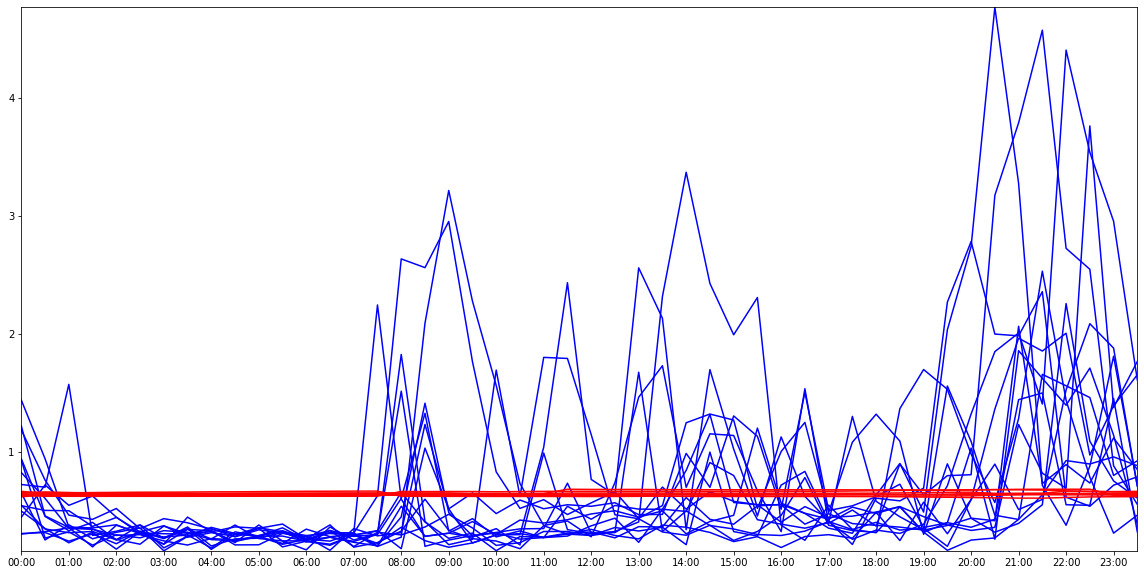

In [132]:
list_labels = daily_meter['label'].unique()
plt.figure(figsize=(20,10))

for label in list_labels:
    df_label = daily_meter.loc[daily_meter['label']==label]
    list_dates = df_label['date'].unique()
    for date in list_dates:
        df_label_date = df_label.loc[df_label['date']==date]
        if label==0:
            plt.plot(df_label_date['time'],df_label_date['power'],'b')
        else:
            plt.plot(df_label_date['time'],df_label_date['power'],'r')

plt.xticks(np.arange(0, 48, step=2))
plt.margins(x=0, y=0)
plt.show()        

# Approach 2
### K-Means + Hourly consumption

Distance measure: Euclidean distance. <br>
Features: Hourly consumption. <br>
Real active.

In [107]:
df_bg.head()

,power,date,time
0,1.184,20090727,00:00
1,0.758,20090727,00:30
2,0.461,20090727,01:00
3,0.425,20090727,01:30
4,0.517,20090727,02:00


In [108]:
list_hours = df_bg['time'].unique()
list_hours

array(['00:00', '00:30', '01:00', '01:30', '02:00', '02:30', '03:00',
       '03:30', '04:00', '04:30', '05:00', '05:30', '06:00', '06:30',
       '07:00', '07:30', '08:00', '08:30', '09:00', '09:30', '10:00',
       '10:30', '11:00', '11:30', '12:00', '12:30', '13:00', '13:30',
       '14:00', '14:30', '15:00', '15:30', '16:00', '16:30', '17:00',
       '17:30', '18:00', '18:30', '19:00', '19:30', '20:00', '20:30',
       '21:00', '21:30', '22:00', '22:30', '23:00', '23:30'], dtype=object)

In [113]:
list_dates = df_bg['date'].unique()
df_a2=pd.DataFrame(columns=['time'])

for date in list_dates:
    df_bg_date = df_bg.loc[df_bg['date']==date]
    df_bg_date = df_bg_date.reset_index()
    df_a2['time'] = df_bg_date['time']
    df_a2[date] = df_bg_date['power']

df_a2=df_a2.set_index('time')
df_a2.head()

,20090727,20090728,20090729,20090730,20090731,20090108,20090208,20090308,20090408,20090508,20090608,20090708,20090808,20090908,20091008,20091108,20091208,20090813,20090814,20090815,20090816
time,,,,,,,,,,,,,,,,,,,,,
00:00,1.184,1.437,0.721,0.541,0.616635,0.628465,0.645399,0.662795,0.651859,0.634108,0.629760,0.822,0.443,0.300,0.305,0.495,0.545,0.939,0.928,0.649,1.218
00:30,0.758,0.939,0.698,0.501,0.632078,0.620896,0.628040,0.645113,0.658130,0.650120,0.633865,0.603,0.717,0.321,0.313,0.347,0.343,0.450,0.266,0.250,0.454
01:00,0.461,0.360,1.571,0.498,0.634582,0.620786,0.627786,0.645026,0.652767,0.650491,0.633925,0.350,0.544,0.353,0.240,0.226,0.312,0.329,0.319,0.379,0.357
01:30,0.425,0.352,0.289,0.365,0.634474,0.620514,0.628599,0.644726,0.648786,0.652323,0.634247,0.341,0.623,0.343,0.301,0.316,0.322,0.399,0.206,0.260,0.191
02:00,0.517,0.379,0.324,0.441,0.633972,0.620543,0.628273,0.644823,0.650592,0.654075,0.634446,0.289,0.444,0.255,0.218,0.172,0.251,0.250,0.294,0.315,0.375


In [114]:
df_a2 = df_a2.T
df_a2

time,00:00,00:30,01:00,01:30,02:00,02:30,03:00,03:30,04:00,04:30,05:00,05:30,06:00,06:30,07:00,07:30,08:00,08:30,09:00,09:30,10:00,10:30,11:00,11:30,12:00,12:30,13:00,13:30,14:00,14:30,15:00,15:30,16:00,16:30,17:00,17:30,18:00,18:30,19:00,19:30,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30
20090727,1.184000,0.758000,0.461000,0.425000,0.517000,0.346000,0.431000,0.396000,0.342000,0.296000,0.354000,0.319000,0.288000,0.305000,0.291000,0.330000,0.176000,1.030000,0.514000,0.650000,0.474000,0.589000,0.515000,0.549000,0.536000,0.566000,0.465000,0.467000,0.985000,0.697000,1.303000,1.130000,0.511000,1.504000,0.500000,0.540000,0.617000,0.723000,0.356000,0.396000,1.030000,0.256000,1.857000,1.622000,1.394000,1.709000,1.140000,0.384000
20090728,1.437000,0.939000,0.360000,0.352000,0.379000,0.302000,0.215000,0.444000,0.319000,0.361000,0.349000,0.385000,0.258000,0.313000,0.308000,0.625000,2.636000,2.562000,2.954000,1.763000,0.828000,0.518000,0.592000,0.466000,0.565000,0.660000,0.431000,0.699000,0.512000,0.659000,0.578000,0.549000,0.401000,0.533000,0.442000,0.452000,0.487000,0.533000,0.448000,0.377000,0.331000,0.357000,1.230000,0.817000,0.690000,3.765000,1.375000,1.766000
20090729,0.721000,0.698000,1.571000,0.289000,0.324000,0.378000,0.265000,0.340000,0.328000,0.208000,0.209000,0.306000,0.277000,0.331000,0.280000,0.298000,0.603000,1.325000,0.325000,0.431000,0.276000,0.327000,0.269000,0.536000,0.426000,0.543000,0.512000,0.510000,0.841000,1.316000,0.568000,0.550000,0.548000,0.384000,0.473000,0.389000,0.374000,0.359000,0.334000,0.373000,0.435000,0.413000,2.064000,0.729000,0.890000,0.733000,1.116000,0.848000
20090730,0.541000,0.501000,0.498000,0.365000,0.441000,0.319000,0.371000,0.273000,0.312000,0.281000,0.348000,0.191000,0.240000,0.214000,0.291000,0.326000,0.655000,0.402000,0.264000,0.308000,0.159000,0.279000,0.273000,0.309000,0.318000,0.268000,0.363000,0.360000,0.610000,0.425000,0.384000,0.539000,0.552000,0.475000,0.350000,0.307000,0.631000,0.899000,0.487000,2.034000,2.742000,4.773000,3.277000,0.714000,0.375000,0.876000,1.810000,0.711000
20090731,0.616635,0.632078,0.634582,0.634474,0.633972,0.633599,0.629533,0.629582,0.629528,0.629576,0.629453,0.629646,0.629656,0.629788,0.629625,0.629637,0.629854,0.628288,0.627524,0.627392,0.627394,0.627304,0.627349,0.627432,0.627540,0.627424,0.628253,0.622811,0.619774,0.619000,0.618948,0.618997,0.618943,0.618750,0.618885,0.618738,0.618080,0.616748,0.614238,0.612731,0.609861,0.607852,0.605377,0.604917,0.610674,0.615425,0.616896,0.617457
20090108,0.628465,0.620896,0.620786,0.620514,0.620543,0.620507,0.620503,0.620828,0.620898,0.621014,0.621016,0.621139,0.621068,0.620903,0.620905,0.621786,0.661979,0.660852,0.661299,0.661042,0.659080,0.661214,0.662714,0.663146,0.663394,0.663488,0.663451,0.663710,0.663620,0.663668,0.663759,0.664595,0.664003,0.663790,0.663780,0.665602,0.668148,0.670385,0.671549,0.671983,0.673783,0.677660,0.679818,0.680637,0.680681,0.680939,0.629352,0.628905
20090208,0.645399,0.628040,0.627786,0.628599,0.628273,0.628031,0.628865,0.629932,0.630075,0.630255,0.630250,0.630844,0.630872,0.631134,0.631212,0.631589,0.633639,0.635745,0.636161,0.635571,0.637477,0.637340,0.637675,0.637840,0.638009,0.637793,0.637632,0.637660,0.637609,0.637481,0.637580,0.637273,0.636995,0.636663,0.636688,0.636609,0.636448,0.635931,0.635833,0.638924,0.643462,0.643523,0.645285,0.645335,0.645653,0.645655,0.645470,0.645373
20090308,0.662795,0.645113,0.645026,0.644726,0.644823,0.644910,0.644811,0.644934,0.645095,0.645033,0.644990,0.644944,0.645012,0.645012,0.645094,0.645439,0.645606,0.645514,0.645434,0.645438,0.645658,0.645665,0.645729,0.648052,0.648318,0.648408,0.648269,0.648234,0.648313,0.648323,0.647672,0.647672,0.647262,0.647108,0.647146,0.646733,0.647497,0.649274,0.651981,0.654773,0.655896,0.644993,0.644200,0.645561,0.664976,0.662806,0.660609,0.662740
20090408,0.651859,0.658130,0.652767,0.648786,0.650592,0.649139,0.648061,0.644892,0.643441,0.645122,0.647733,0.647743,0.647908,0.648837,0.649292,0.649186,0.649405,0.648929,0.648639

In [115]:
df_features_2 = df_a2.copy()

# Importing StandardScaler method for SkLearn 
from sklearn.preprocessing import StandardScaler

# Creating the instance for Standard Scaler 
scaler = StandardScaler()

# Fitting the scaler with meter_stat
scaler.fit(df_features_2)

# Transforming the meter_stat df into an scaled one. 
df_features_scaled_2 = pd.DataFrame(scaler.transform(df_features_2), index=df_features_2.index, columns=df_features_2.columns)

In [116]:
df_features_scaled_2.head()

time,00:00,00:30,01:00,01:30,02:00,02:30,03:00,03:30,04:00,04:30,05:00,05:30,06:00,06:30,07:00,07:30,08:00,08:30,09:00,09:30,10:00,10:30,11:00,11:30,12:00,12:30,13:00,13:30,14:00,14:30,15:00,15:30,16:00,16:30,17:00,17:30,18:00,18:30,19:00,19:30,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30
20090727,1.666308,1.181986,-0.185742,-0.079026,0.531603,-0.496738,0.185951,-0.191045,-0.344539,-0.603976,-0.357579,-0.499175,-0.519318,-0.557774,-0.589654,-0.400741,-0.945657,0.374930,-0.242121,0.113010,-0.217730,0.682238,-0.203568,-0.205050,0.077952,0.309386,-0.417765,-0.499167,0.406478,-0.280057,1.411665,1.069168,-0.267604,2.388579,0.038728,-0.000466,0.262125,0.340444,-0.691925,-0.691822,0.241434,-0.711876,0.601726,0.397305,0.170490,0.496486,0.156195,-1.057753
20090728,2.563463,2.182648,-0.549386,-0.524962,-0.293883,-0.779493,-1.012414,0.115628,-0.476595,-0.227527,-0.388054,-0.115203,-0.682668,-0.511988,-0.493560,0.285166,3.365004,2.922032,2.848137,2.347918,0.681180,0.292608,0.018854,-0.369310,0.215794,0.936574,-0.480644,-0.082927,-0.337401,-0.356197,-0.350092,-0.274721,-0.781387,-0.396049,-0.458240,-0.338839,-0.357301,-0.399533,-0.376969,-0.725519,-0.809776,-0.618974,-0.067653,-0.442390,-0.575424,2.680587,0.554095,2.507223
20090729,0.024481,0.850275,3.810739,-0.909811,-0.622882,-0.291098,-0.735015,-0.548831,-0.424921,-1.113628,-1.241350,-0.574806,-0.579213,-0.408971,-0.651833,-0.475145,-0.197425,0.865396,-0.481489,-0.326742,-0.720510,-0.755552,-0.914165,-0.230777,-0.444897,0.155925,-0.330844,-0.422019,0.180012,0.960225,-0.374392,-0.272408,-0.094786,-0.823351,-0.192619,-0.581083,-0.895725,-1.077196,-0.767240,-0.732614,-0.653373,-0.567464,0.822717,-0.534182,-0.363517,-0.540325,0.115558,0.139171
20090730,-0.613811,-0.238843,-0.052526,-0.445549,0.076987,-0.670247,-0.146928,-0.976896,-0.516787,-0.690848,-0.394149,-1.243848,-0.780679,-1.078584,-0.589654,-0.410042,-0.106305,-0.669183,-0.558746,-0.573727,-1.017608,-1.018964,-0.902610,-0.680019,-0.958239,-1.678932,-0.606403,-0.691141,-0.183278,-0.825060,-0.821514,-0.297852,-0.076103,-0.562381,-1.246534,-0.896386,0.328832,1.025897,-0.243455,2.213218,2.816073,3.442943,2.117702,-0.549829,-0.909178,-0.388415,1.290633,-0.214231
20090731,-0.345603,0.485825,0.439227,1.200590,1.231306,1.351443,1.287408,1.301314,1.306329,1.327935,1.321298,1.308088,1.341004,1.301050,1.324465,0.295948,-0.150368,-0.292956,-0.098342,0.067614,0.171783,0.892439,0.120963,-0.049829,0.513056,0.719217,-0.115846,-0.219621,-0.167906,-0.436344,-0.250588,-0.112815,0.236570,-0.150136,1.057387,0.302293,0.267270,-0.073366,0.192136,-0.307444,-0.390403,-0.388235,-0.734494,-0.663613,-0.659473,-0.665225,-0.729520,-0.455533


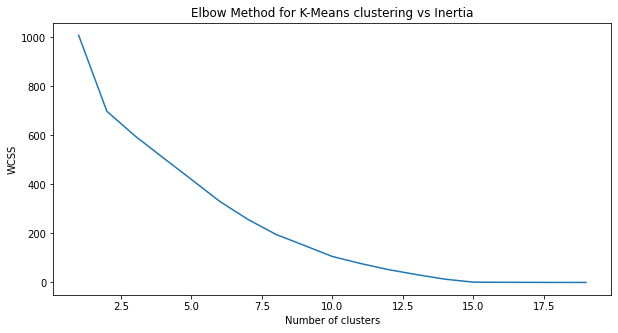

In [117]:
# Importing the library for KMeans 
from sklearn.cluster import KMeans

# Creating an empty list 
wcss = []

#ELBOW METHOD
# Creating a for loop for clusters between 1 and 12. 
# We create an instance, we fit the model and calculate the inertia 
for i in range(1, 20):
    kmeans = KMeans(n_clusters = i, init = "k-means++", max_iter = 300, n_init = 10, random_state = 42)
    kmeans.fit(df_features_scaled_2)
    wcss.append (kmeans.inertia_)
# Plotting the inertia in front of each iteration 
plt.figure(figsize=(10,5))
plt.plot(range(1, 20), wcss)

# Setting aesthetics of the plot. 
plt.title('Elbow Method for K-Means clustering vs Inertia')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.show()

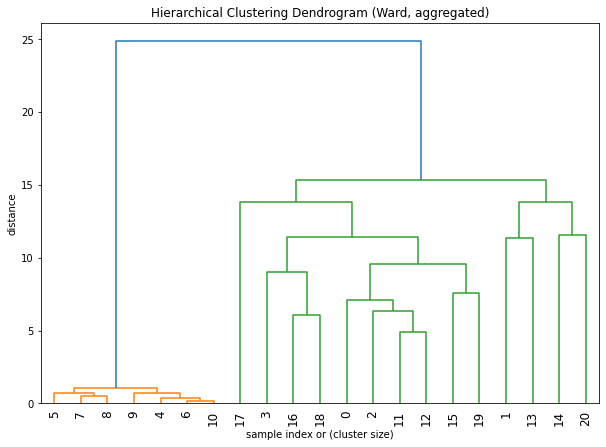

In [118]:
#DENDOGRAM METHOD

# Hierarchical algorithm for clustering. Import hierarchical algorithm method. 
from scipy.cluster.hierarchy import dendrogram, linkage

# Creating a new hierarchical algorithm  
linkage_matrix = linkage(df_features_scaled_2, 'ward')

# Creating the figure 
figure = plt.figure(figsize=(10, 7))

# The hierarchical algorithm will be reduced, only showing the converged clusters.
dendrogram(
    linkage_matrix,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=24,                   # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,   # to get a distribution impression in truncated branches
)

# Setting aesthetics of the plot 
plt.title('Hierarchical Clustering Dendrogram (Ward, aggregated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
plt.show()

In [119]:
#CLUSTERING
# We assume 2 clusters 
kmeans = KMeans(n_clusters=2)

# Fitting the input data
kmeans.fit(df_features_scaled_2)

# Including the labels in the database 
df_features_2['labels'] = kmeans.labels_

In [120]:
# Counting the number of clients under each label. 
df_features_2['labels'].value_counts()

0    14
1     7
Name: labels, dtype: int64

In [121]:
print(f"The inertia of the model with k=2 is {kmeans.inertia_}")

The inertia of the model with k=2 is 698.3997824931996


In [122]:
df_features_2[df_features_2.index=='20090727']

time,00:00,00:30,01:00,01:30,02:00,02:30,03:00,03:30,04:00,04:30,05:00,05:30,06:00,06:30,07:00,07:30,08:00,08:30,09:00,09:30,10:00,10:30,11:00,11:30,12:00,12:30,13:00,13:30,14:00,14:30,15:00,15:30,16:00,16:30,17:00,17:30,18:00,18:30,19:00,19:30,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,labels
20090727,1.184,0.758,0.461,0.425,0.517,0.346,0.431,0.396,0.342,0.296,0.354,0.319,0.288,0.305,0.291,0.33,0.176,1.03,0.514,0.65,0.474,0.589,0.515,0.549,0.536,0.566,0.465,0.467,0.985,0.697,1.303,1.13,0.511,1.504,0.5,0.54,0.617,0.723,0.356,0.396,1.03,0.256,1.857,1.622,1.394,1.709,1.14,0.384,0


In [123]:
df_features_2[df_features_2.index=='20090108']

time,00:00,00:30,01:00,01:30,02:00,02:30,03:00,03:30,04:00,04:30,05:00,05:30,06:00,06:30,07:00,07:30,08:00,08:30,09:00,09:30,10:00,10:30,11:00,11:30,12:00,12:30,13:00,13:30,14:00,14:30,15:00,15:30,16:00,16:30,17:00,17:30,18:00,18:30,19:00,19:30,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,labels
20090108,0.628465,0.620896,0.620786,0.620514,0.620543,0.620507,0.620503,0.620828,0.620898,0.621014,0.621016,0.621139,0.621068,0.620903,0.620905,0.621786,0.661979,0.660852,0.661299,0.661042,0.65908,0.661214,0.662714,0.663146,0.663394,0.663488,0.663451,0.66371,0.66362,0.663668,0.663759,0.664595,0.664003,0.66379,0.66378,0.665602,0.668148,0.670385,0.671549,0.671983,0.673783,0.67766,0.679818,0.680637,0.680681,0.680939,0.629352,0.628905,1


In [125]:
v_label=[]
daily_meter_2 = daily_meter.copy()
for ind in daily_meter_2.index:
    date = daily_meter_2['date'][ind]
    if date in df_features_2.index:
        v_label=v_label+[df_features_2['labels'][date]]
    else:
        v_label=v_label+['NaN']
daily_meter_2['label']=v_label
daily_meter_2.head()

,time,date,power,norm_power,label
index,,,,,
0,00:00,20090727,1.184,0.637588,0
1,00:30,20090727,0.758,0.408185,0
2,01:00,20090727,0.461,0.248250,0
3,01:30,20090727,0.425,0.228864,0
4,02:00,20090727,0.517,0.278406,0


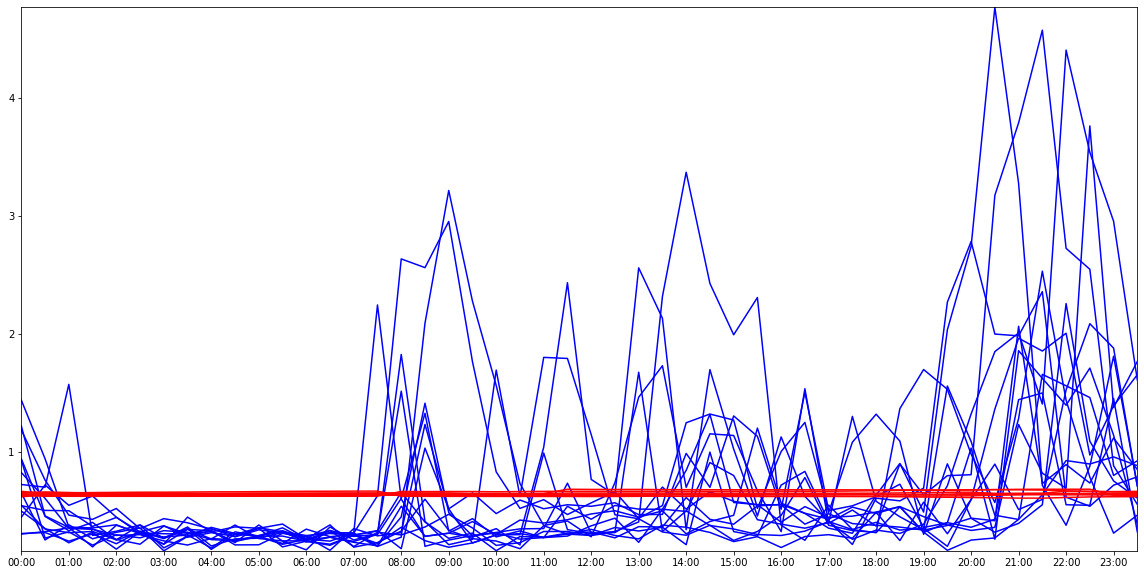

In [133]:
list_labels = daily_meter_2['label'].unique()
plt.figure(figsize=(20,10))

for label in list_labels:
    df_label = daily_meter_2.loc[daily_meter_2['label']==label]
    list_dates = df_label['date'].unique()
    for date in list_dates:
        df_label_date = df_label.loc[df_label['date']==date]
        if label==0:
            plt.plot(df_label_date['time'],df_label_date['power'],'b')
        else:
            plt.plot(df_label_date['time'],df_label_date['power'],'r')
            
plt.xticks(np.arange(0, 48, step=2))
plt.margins(x=0, y=0)
plt.show()        

# 3. K-Means
Distance measure: Dynamic Time Warping (DTW). <br>
Features: Hourly consumption. <br>
Normalized Active.

In [134]:
from tslearn.metrics import dtw
from tslearn.clustering import TimeSeriesKMeans

In [135]:
cluster_h_dtw = df_cluster
df_features_3 = df_features_2
df_features_scaled_3 = df_features_scaled_2

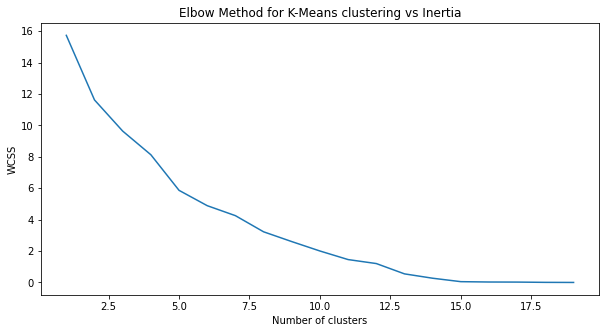

In [136]:
# Creating an empty list 
wcss = []

#ELBOW METHOD
# Creating a for loop for clusters between 1 and 12. 
# We create an instance, we fit the model and calculate the inertia 
for i in range(1, 20):
    kmeans_dtw = TimeSeriesKMeans(n_clusters = i, metric='dtw', max_iter = 10)
    kmeans_dtw.fit(df_features_scaled_3)
    wcss.append (kmeans_dtw.inertia_)
# Plotting the inertia in front of each iteration 
plt.figure(figsize=(10,5))
plt.plot(range(1, 20), wcss)

# Setting aesthetics of the plot. 
plt.title('Elbow Method for K-Means clustering vs Inertia')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.show()

In [137]:
#CLUSTERING
# We assume 3 clusters 
kmeans_dtw = TimeSeriesKMeans(n_clusters = 2, metric='dtw', max_iter = 10)

# Fitting the input data
kmeans_dtw.fit(df_features_scaled_3)

# Including the labels in the database 
df_features_3['labels'] = kmeans_dtw.labels_

In [138]:
# Counting the number of clients under each label. 
df_features_3['labels'].value_counts()

0    12
1     9
Name: labels, dtype: int64

In [140]:
print(f"The inertia of the model with k=2 is {kmeans_dtw.inertia_}")

The inertia of the model with k=2 is 11.177927430802058


In [142]:
df_features_3[df_features_3.index=='20090727']

time,00:00,00:30,01:00,01:30,02:00,02:30,03:00,03:30,04:00,04:30,05:00,05:30,06:00,06:30,07:00,07:30,08:00,08:30,09:00,09:30,10:00,10:30,11:00,11:30,12:00,12:30,13:00,13:30,14:00,14:30,15:00,15:30,16:00,16:30,17:00,17:30,18:00,18:30,19:00,19:30,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,labels
20090727,1.184,0.758,0.461,0.425,0.517,0.346,0.431,0.396,0.342,0.296,0.354,0.319,0.288,0.305,0.291,0.33,0.176,1.03,0.514,0.65,0.474,0.589,0.515,0.549,0.536,0.566,0.465,0.467,0.985,0.697,1.303,1.13,0.511,1.504,0.5,0.54,0.617,0.723,0.356,0.396,1.03,0.256,1.857,1.622,1.394,1.709,1.14,0.384,0


In [143]:
df_features_3[df_features_3.index=='20090108']

time,00:00,00:30,01:00,01:30,02:00,02:30,03:00,03:30,04:00,04:30,05:00,05:30,06:00,06:30,07:00,07:30,08:00,08:30,09:00,09:30,10:00,10:30,11:00,11:30,12:00,12:30,13:00,13:30,14:00,14:30,15:00,15:30,16:00,16:30,17:00,17:30,18:00,18:30,19:00,19:30,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,labels
20090108,0.628465,0.620896,0.620786,0.620514,0.620543,0.620507,0.620503,0.620828,0.620898,0.621014,0.621016,0.621139,0.621068,0.620903,0.620905,0.621786,0.661979,0.660852,0.661299,0.661042,0.65908,0.661214,0.662714,0.663146,0.663394,0.663488,0.663451,0.66371,0.66362,0.663668,0.663759,0.664595,0.664003,0.66379,0.66378,0.665602,0.668148,0.670385,0.671549,0.671983,0.673783,0.67766,0.679818,0.680637,0.680681,0.680939,0.629352,0.628905,0


In [146]:
v_label=[]
daily_meter_3 = daily_meter.copy()
for ind in daily_meter_3.index:
    date = daily_meter_3['date'][ind]
    if date in df_features_3.index:
        v_label=v_label+[df_features_3['labels'][date]]
    else:
        v_label=v_label+['NaN']
daily_meter_3['label']=v_label
daily_meter_3.head()

,time,date,power,norm_power,label
index,,,,,
0,00:00,20090727,1.184,0.637588,0
1,00:30,20090727,0.758,0.408185,0
2,01:00,20090727,0.461,0.248250,0
3,01:30,20090727,0.425,0.228864,0
4,02:00,20090727,0.517,0.278406,0


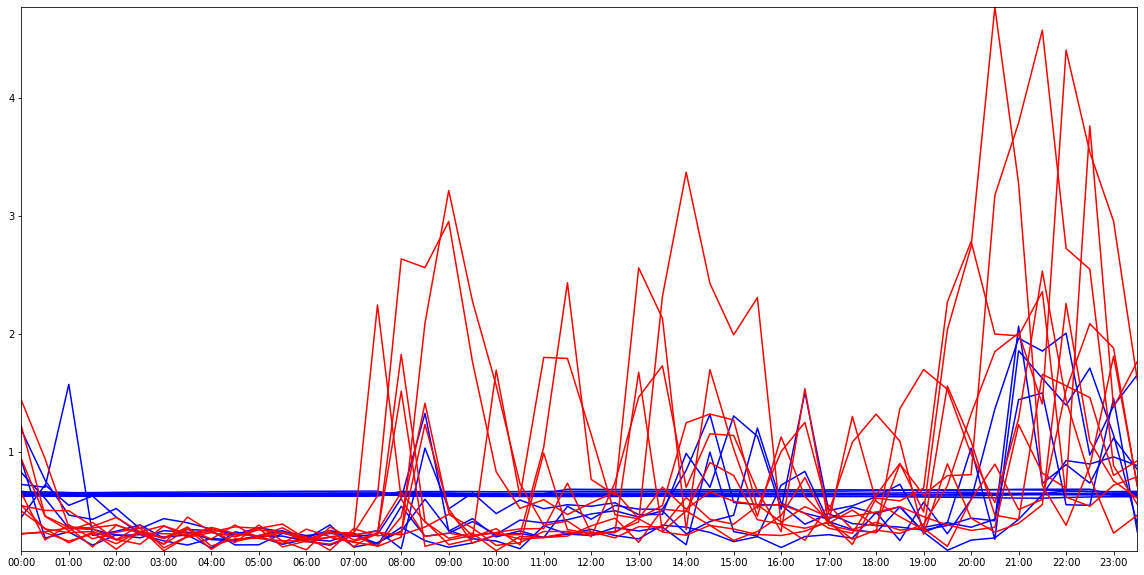

In [147]:
list_labels = daily_meter_3['label'].unique()
plt.figure(figsize=(20,10))

for label in list_labels:
    df_label = daily_meter_3.loc[daily_meter_3['label']==label]
    list_dates = df_label['date'].unique()
    for date in list_dates:
        df_label_date = df_label.loc[df_label['date']==date]
        if label==0:
            plt.plot(df_label_date['time'],df_label_date['power'],'b')
        else:
            plt.plot(df_label_date['time'],df_label_date['power'],'r')
            
plt.xticks(np.arange(0, 48, step=2))
plt.margins(x=0, y=0)
plt.show()        